In [1]:
import networkx  as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backbone_disparity import disparity_filter


In [2]:
df = pd.read_pickle('../../Files/test_0613_cross.pickle')
ratio3 = pd.read_pickle('../../Files/test_0613_ratio_temp3.pickle')
ratio2 = pd.read_pickle('../../Files/test_0613_ratio_temp2.pickle')
ratio = pd.concat([ratio3, ratio2])

In [3]:
ratio = pd.concat([ratio3, ratio2])
ratio.head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
0,COVID19,3,69,7833,0.000383,0.008809
1,Coronavirus,2,87,8000,0.000250,0.010875
2,CovidVaccinated,21,127,8000,0.002625,0.015875
3,DebateVaccines,311,76,2580,0.120543,0.029457
4,HermanCainAward,15,0,42,0.357143,0.000000


# Graph & Backboning

In [12]:
G = nx.Graph()

In [13]:
t = df['subreddit'].drop_duplicates().to_list()
t.extend(df['crosspost_parent'].drop_duplicates().to_list())
res = []
for i in t:
    if i not in res:
        res.append(i)
G.add_nodes_from(res)

In [14]:
e = df[['subreddit', 'crosspost_parent', 'count']].values.tolist()

In [15]:
for u, v, weight in e:
    G.add_edge(u, v)
    G[u][v]['weight'] = weight

In [16]:
alpha = 0.05
G = disparity_filter(G)
G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])
print('alpha = %s' % alpha)
print('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
print('backbone: nodes = %s, edges = %s' % (G2.number_of_nodes(), G2.number_of_edges()))



alpha = 0.05
original: nodes = 9354, edges = 28200
backbone: nodes = 839, edges = 1152


### Trying with minimum limit on number of crossposts

In [22]:
G3 = nx.Graph()
t = df['subreddit'].drop_duplicates().to_list()
t.extend(df['crosspost_parent'].drop_duplicates().to_list())
res = []
for i in t:
    if i not in res:
        res.append(i)
G3.add_nodes_from(res)
for u, v, weight in e:
    if weight >= 5: # trying a filter of 5 to eliminate spurious connections
        G3.add_edge(u, v)
        G3[u][v]['weight'] = weight

In [23]:
print(f'Nodes: {len(G3.nodes)}, Edges: {len(G3.edges)}')

Nodes: 9375, Edges: 3384


In [30]:
# get number of edges from graph
print(f'Nodes: {len(G.nodes)}, Edges: {len(G.edges)}')

Nodes: 9354, Edges: 28200


In [25]:
alpha = 0.05
G3 = disparity_filter(G3)
G4 = nx.Graph([(u, v, d) for u, v, d in G3.edges(data=True) if d['alpha'] < alpha])
print('alpha = %s' % alpha)
print('original: nodes = %s, edges = %s' % (G3.number_of_nodes(), G3.number_of_edges()))
print('backbone: nodes = %s, edges = %s' % (G4.number_of_nodes(), G4.number_of_edges()))


alpha = 0.05
original: nodes = 1386, edges = 3380
backbone: nodes = 180, edges = 164


In [27]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):

    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

Text(0, 0.5, 'Frequency')

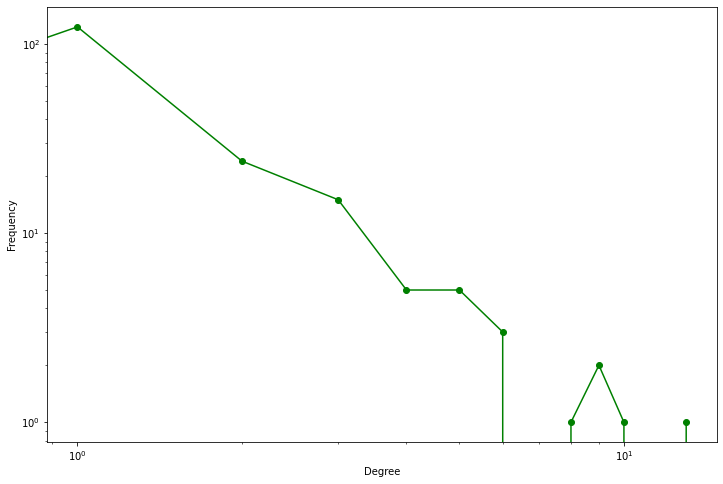

In [28]:
in_degree_freq = degree_histogram_directed(G4, )
# out_degree_freq = degree_histogram_directed(G2, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
# plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

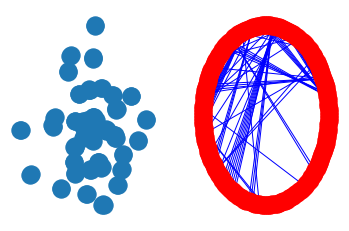

In [29]:
import matplotlib.pyplot as plt

subax1 = plt.subplot(121)
nx.draw(G4)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G4, pos=nx.circular_layout(G4), node_color='r', edge_color='b')

In [30]:
print(list(nx.connected_components(G4)))
print(nx.number_connected_components(G4))

[{'sciencememes', 'dankmemes', 'awfuleverything', 'WTF', 'Wellthatsucks', 'RepublicanValues', 'funnysigns', 'mildlypenis', 'southafrica', 'wholesomememes', 'PublicFreakout', 'NoahGetTheBoat', 'Cringetopia', 'insanepeoplefacebook', 'conspiracyfact', 'facepalm', 'JordanPeterson', 'confidentlyincorrect', 'aspiememes', 'TikTokHumor', 'artmemes', 'CapitolConsequences', 'HolUp', 'trippinthroughtime', 'blursedimages', 'nextfuckinglevel', 'FuckYouKaren', 'adhdmeme', 'Qult_Headquarters', 'NoShitSherlock', 'iamatotalpieceofshit', 'TheFightThatMatters', 'anime_titties', 'theyknew', 'funny', 'mildlyinfuriating', 'tumblr', 'CrappyDesign', 'conspiracytheories', 'Bad_Cop_No_Donut', 'LeopardsAteMyFace', 'science', 'Astuff', 'labor', 'Damnthatsinteresting', 'WinStupidPrizes', 'MakeMeSuffer', 'Whatcouldgowrong', 'HongKong', 'news', 'DunderMifflin', 'ABoringDystopia', 'Unexpected', 'oddlysatisfying', 'Rakingthemuck', 'nottheonion', 'politics', 'PBS_NewsHour', 'democrats', 'worldnews', 'oddlyterrifying', 

In [35]:
for j in list(nx.connected_components(G2)):
    print(j)
    print(len(j))
    print('\n')

{'SurprisingNoOne', 'progressive', 'The_Ultimate', 'VirginiaPolitics', 'afdwatch', 'UNBGBBIIVCHIDCTIICBG', 'CovIdiots', 'itookapicture', 'EUnews', 'entitledparentsmemes', 'ShitLiberalsSay', 'FUCKYOUINPARTICULAR', 'January6', 'Calgary', 'starterpacks', 'australia', 'redsports', 'uspolitics', 'BeansInThings', 'technews', 'AskWomenOfColorOver30', 'lebanon', 'SweatyPalms', 'ireland', 'GAA', 'tumblr', 'NoShitSherlock', 'FuckYouKaren', 'regenerate', 'vacci_nation', 'Shitstatistssay', 'HistoryMemes', 'blessedimages', 'interestingasfuck', 'TheNarcoblog701', 'islam', 'gifs', 'taiwan', 'houstonmusic', 'Bossfight', 'Jung', 'DunderMifflin', 'labor', 'CoronaKritiker', 'ThatLookedExpensive', 'awfuleverything', 'ShitAmericansSay', 'basicincomejapan', 'worldnews247', 'INTP', 'crappyoffbrands', 'wholesomememes', 'onguardforthee', 'sanepolitics', 'coronabr', 'Fuck45', 'HUEstation', 'TumblrInAction', 'AmericanPandemics', 'instantkarma', '196', 'AnythingGoesNews', 'WesternCivilisation', 'BhutilaKarpoche',

In [36]:
lst = list(nx.connected_components(G2))

In [41]:
'Arkansas' in lst[1]

True

In [36]:
df2 = pd.DataFrame.from_dict(nx.degree_centrality(G2), orient='index', columns=['degree_centrality', ''])
df2 = df2.reset_index().rename(columns={'index': 'subreddit'})
df2['closeness_centrality'] = df2['subreddit'].map(nx.closeness_centrality(G2))
df2['degree'] = df2['subreddit'].map(G2.degree)

df2.head()

,subreddit,degree_centrality,closeness_centrality,degree
0,2meirl4meirl,0.001193,0.182771,1
1,aspiememes,0.039379,0.230555,33
2,PrequelMemes,0.002387,0.182977,2
3,sciencememes,0.004773,0.207315,4
4,dankmemes,0.013126,0.266148,11


In [37]:
df2.sort_values('degree_centrality',ascending=False).head()

,subreddit,degree_centrality,closeness_centrality,degree
10,JustUnsubbed,0.068019,0.262599,57
30,RuralNewsNetwork,0.048926,0.214925,41
5,ABoringDystopia,0.048926,0.274813,41
80,PublicFreakout,0.047733,0.270242,40
1,aspiememes,0.039379,0.230555,33


In [49]:
df2.to_csv('../../Files/subs_backboned.csv')

# Analysis

In [4]:
ratio.sort_values('crosspost_parent_%', ascending=False).head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
154,RimBob,39,0,39,1.000000,0.0
164,SurprisingNoOne,61,0,61,1.000000,0.0
291,patient_hackernews,6775,0,6781,0.999115,0.0
232,corruptscience,53,0,55,0.963636,0.0
168,TheFightThatMatters,1762,0,1852,0.951404,0.0


In [5]:
ratio.sort_values('crosspost_child_%', ascending=False).head()

,subreddit,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%
182,TruthLeaks,148,280,1280,0.115625,0.218750
250,hackernews,0,1183,7743,0.000000,0.152783
3,ATBGE,29,1104,7739,0.003747,0.142654
215,blursedimages,1,1098,8000,0.000125,0.137250
79,EnrichYourJourney,5,1,8,0.625000,0.125000


In [6]:
df2 = pd.read_csv('../../Files/subs_backboned.csv')

In [7]:
df3 = df2.merge(ratio, left_on='subreddit', right_on='subreddit', how='left')

In [8]:
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
len(df3)

839

In [10]:
df3.mean()

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_44051/3891983329.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df3.mean()


degree_centrality          0.003277
closeness_centrality       0.166971
degree                     2.746126
crosspost_parent         414.850394
crosspost_child           54.724409
total                   5239.251969
crosspost_parent_%         0.145180
crosspost_child_%          0.010709
dtype: float64

In [11]:
df3['crosspost_parent'].isna().sum()

585

In [2]:
import praw

CLIENT_ID = '5FpjYNUrv93rDqflbNE-6w'
CLIENT_SECRET = '5ZITWnmNd6_qCbPXDB90xmOaIMo9_w'
USER_NAME = 'theonejay96'
SCRIPT_NAME = 'Data\ Science\ Thesis'
LOGIN_PASSWORD = 'vejkyz-hyBfez-4cinte'

reddit =  praw.Reddit(
    client_id= CLIENT_ID ,
    client_secret= CLIENT_SECRET ,
    user_agent= SCRIPT_NAME,
    username= USER_NAME,
    password= LOGIN_PASSWORD)


Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


In [17]:
df3['subscribers'] = 0
df3['language'] = ''

In [18]:
from tqdm import tqdm
error = 0
for i, j in tqdm(df3.iterrows()):
    try:
        subreddit = reddit.subreddit(df3.loc[i]['subreddit'])
        df3.at[i,'subscribers'] = subreddit.subscribers
        df3.at[i,'language'] = subreddit.lang
    except:
        error += 1
        continue

839it [12:35,  1.11it/s]


In [55]:
error

42

In [56]:
df5 = df3[df3['language'] == '']

In [58]:
df5.shape

(42, 12)

In [106]:
df5.head(42)

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language,component
97,SocialJusticeInAction,0.003580,0.193375,3,0.0,50.0,7167.0,0.000000,0.006976,0,,0
98,TheNarcoblog701,0.002387,0.191044,2,NaN,NaN,NaN,NaN,NaN,0,,0
110,ArkansasJobsForAll,0.001193,0.001591,1,NaN,NaN,NaN,NaN,NaN,0,,1
144,CoronavirusVariants,0.001193,0.174338,1,86.0,2.0,461.0,0.186551,0.004338,0,,0
147,NoLockdownsNoMasks,0.001193,0.205026,1,201.0,4.0,1551.0,0.129594,0.002579,0,,0
158,SynergyScience,0.001193,0.001193,1,NaN,NaN,NaN,NaN,NaN,0,,3
163,Cringetopia,0.005967,0.238770,5,NaN,NaN,NaN,NaN,NaN,0,,0
176,Brand_Insider,0.001193,0.159846,1,NaN,NaN,NaN,NaN,NaN,0,,0
200,GenZedong,0.001193,0.178210,1,NaN,NaN,NaN,NaN,NaN,0,,0
247,kotakuinaction2,0.001193,0.198696,1,0.0,12.0,3328.0,0.000000,0.003606,0,,0


In [19]:
df3.head()

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language
0,2meirl4meirl,0.001193,0.182771,1,NaN,NaN,NaN,NaN,NaN,1394898,en
1,aspiememes,0.039379,0.230555,33,1987.0,29.0,5976.0,0.332497,0.004853,111974,en
2,PrequelMemes,0.002387,0.182977,2,NaN,NaN,NaN,NaN,NaN,2141182,en
3,sciencememes,0.004773,0.207315,4,310.0,6.0,2556.0,0.121283,0.002347,325440,en
4,dankmemes,0.013126,0.266148,11,0.0,56.0,8000.0,0.000000,0.007000,5771321,en


In [44]:
df3['component'] = ''
for i, j in tqdm(df3.iterrows()):
    for k in range(len(lst)):
        if df3.loc[i]['subreddit'] in lst[k]:
            df3.at[i, 'component'] = k


839it [00:03, 252.40it/s]


In [50]:
df3.dtypes

subreddit                object
degree_centrality       float64
closeness_centrality    float64
degree                    int64
crosspost_parent        float64
crosspost_child         float64
total                   float64
crosspost_parent_%      float64
crosspost_child_%       float64
subscribers               int64
language                 object
component                object
dtype: object

In [23]:

df4 = df3[df3['subscribers'] > 500000]

In [24]:
df4

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language
0,2meirl4meirl,0.001193,0.182771,1,NaN,NaN,NaN,NaN,NaN,1394898,en
2,PrequelMemes,0.002387,0.182977,2,NaN,NaN,NaN,NaN,NaN,2141182,en
4,dankmemes,0.013126,0.266148,11,0.0,56.0,8000.0,0.000000,0.007000,5771321,en
5,ABoringDystopia,0.048926,0.274813,41,2974.0,43.0,8000.0,0.371750,0.005375,733281,en
9,FuckYouKaren,0.021480,0.236168,18,1458.0,44.0,7779.0,0.187428,0.005656,1355649,en
...,...,...,...,...,...,...,...,...,...,...,...
751,ArtefactPorn,0.001193,0.197849,1,NaN,NaN,NaN,NaN,NaN,2548304,pl
752,DataHoarder,0.001193,0.197849,1,NaN,NaN,NaN,NaN,NaN,632822,en
803,boston,0.001193,0.001193,1,NaN,NaN,NaN,NaN,NaN,546081,en
809,Filmmakers,0.003580,0.003580,3,149.0,18.0,7000.0,0.021286,0.002571,2668444,en


In [53]:
df3.to_csv('../../Files/subs_backboned_subscribers.csv')

# Define Subs to pull

In [2]:
df3 = pd.read_csv('../../Files/subs_backboned_subscribers.csv')

In [3]:
df3 = df3.drop(['Unnamed: 0'], axis=1)

In [4]:
df3.head()

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language,component
0,2meirl4meirl,0.001193,0.182771,1,NaN,NaN,NaN,NaN,NaN,1394898,en,0
1,aspiememes,0.039379,0.230555,33,1987.0,29.0,5976.0,0.332497,0.004853,111974,en,0
2,PrequelMemes,0.002387,0.182977,2,NaN,NaN,NaN,NaN,NaN,2141182,en,0
3,sciencememes,0.004773,0.207315,4,310.0,6.0,2556.0,0.121283,0.002347,325440,en,0
4,dankmemes,0.013126,0.266148,11,0.0,56.0,8000.0,0.000000,0.007000,5771321,en,0


<AxesSubplot:xlabel='language'>

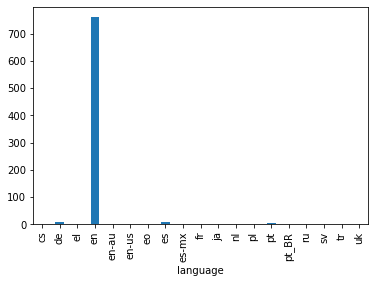

In [5]:
groupedLang = df3.groupby(by='language').size()
groupedLang.plot.bar()

<AxesSubplot:xlabel='component'>

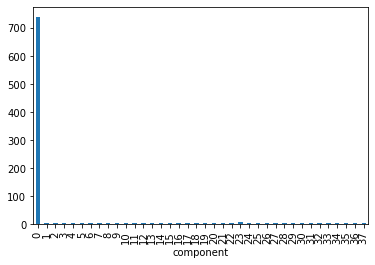

In [6]:
groupedcomp = df3.groupby(by='component').size()
groupedcomp.plot.bar()

array([[<AxesSubplot:title={'center':'closeness_centrality'}>,
        <AxesSubplot:title={'center':'degree'}>,
        <AxesSubplot:title={'center':'degree_centrality'}>],
       [<AxesSubplot:title={'center':'crosspost_parent'}>,
        <AxesSubplot:title={'center':'crosspost_child'}>,
        <AxesSubplot:title={'center':'total'}>],
       [<AxesSubplot:title={'center':'subscribers'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

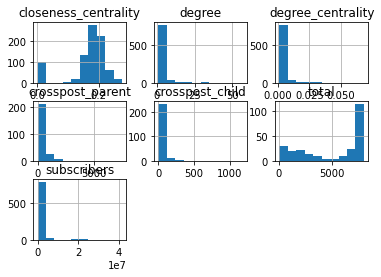

In [7]:
df3.hist(column=['closeness_centrality', 'degree', 'degree_centrality', 'crosspost_parent', 'crosspost_child', 'total', 'subscribers' ])

In [8]:
df6 = df3[(df3['language'] != 'en') & (df3['language'] != 'en-us') & (df3['language'] != 'en-uk') & (df3['language'] != '') & (~df3['language'].isna())]

In [9]:
foreign_lang_eng = ['AskReddit', 'CoronaVirusMemes', 'Instagramreality', 'TheLastAirbender', 'mildlyvagina', 'Wallstreetsilver', 'ArtefactPorn']

In [10]:
df7 = df6[~df6.subreddit.isin(foreign_lang_eng)]

In [11]:
df8 = pd.concat([df3, df7, df7]).drop_duplicates(keep=False)

## Remove subs from other components except specific Subs of Interes

In [12]:
df9 = df8[df8['component'] != 0]

In [13]:
keep_comp = ['CoronavirusMa', 'CoronavirusWA', 'Covidmx', 'censoredreality', 'IVMScience', 'ivermectin']

In [14]:
df10 = df9[~df9.subreddit.isin(keep_comp)]

In [15]:
df11 = pd.concat([df8, df10, df10]).drop_duplicates(keep=False)

## Remove large unrelated subs

In [16]:
df12 = df11[df11['subscribers'] < 500000]
smallsubs = df12.subreddit.to_list()

In [17]:
df13 = df11[df11['subscribers'] >= 500000]

In [23]:
import csv
file = open("smallsubs.csv", "w")
writer = csv.writer(file, delimiter = "\n")
for list_ in smallsubs:
     writer.writerow([list_])
file.close()

In [18]:
drop_large = ['Minecraft', 'pcmasterrace', 'AnimalsBeingBros', 'AnimalsBeingDerps', 'AnimalsBeingJerks', \
    'cats', 'ArtefactPorn', 'PrequelMemes', 'DunderMifflin', 'skyrim', 'lotrmemes', 'BoneAppleTea', \
    'dndmemes', 'AmongUs', 'Gamingcirclejerk']

In [19]:
df14 = df13[~df13.subreddit.isin(drop_large)]

In [20]:
df12.sort_values(by='subscribers')

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language,component
450,DebateVaccine,0.001193,0.177869,1,242.0,2.0,632.0,0.382911,0.003165,0,NaN,0
718,vaccinesideeffects,0.001193,0.149685,1,NaN,NaN,NaN,NaN,NaN,0,NaN,0
97,SocialJusticeInAction,0.003580,0.193375,3,0.0,50.0,7167.0,0.000000,0.006976,0,NaN,0
98,TheNarcoblog701,0.002387,0.191044,2,NaN,NaN,NaN,NaN,NaN,0,NaN,0
717,VaccineEnvy,0.001193,0.149685,1,NaN,NaN,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
530,conspiracytheories,0.001193,0.192973,1,132.0,37.0,7152.0,0.018456,0.005173,477958,en,0
389,geopolitics,0.001193,0.163382,1,NaN,NaN,NaN,NaN,NaN,485566,en,0
543,technews,0.001193,0.184169,1,NaN,NaN,NaN,NaN,NaN,491996,en,0
12,theyknew,0.028640,0.247688,24,2041.0,46.0,7625.0,0.267672,0.006033,492335,en,0


In [ ]:
largesubs = df14.subreddit.to_list()
import csv
file = open("largesubs.csv", "w")
writer = csv.writer(file, delimiter = "\n")
for list_ in largesubs:
     writer.writerow([list_])
file.close()

In [21]:
df15 = df12.append(df14)

/var/folders/fh/yf9jwszj6d5_1_xhfz_l6k000000gn/T/ipykernel_3767/2535302615.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df15 = df12.append(df14)


In [22]:
df15

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language,component
1,aspiememes,0.039379,0.230555,33,1987.0,29.0,5976.0,0.332497,0.004853,111974,en,0
3,sciencememes,0.004773,0.207315,4,310.0,6.0,2556.0,0.121283,0.002347,325440,en,0
6,Anarcho_Capitalism,0.036993,0.272852,31,2039.0,122.0,8000.0,0.254875,0.015250,189088,en,0
7,ConservativeMemes,0.009547,0.229577,8,414.0,101.0,8000.0,0.051750,0.012625,59432,en,0
8,CoronavirusCirclejerk,0.026253,0.267132,22,1153.0,89.0,8000.0,0.144125,0.011125,51174,en,0
...,...,...,...,...,...,...,...,...,...,...,...,...
679,nyc,0.001193,0.170810,1,NaN,NaN,NaN,NaN,NaN,661026,en,0
680,woahdude,0.001193,0.189762,1,NaN,NaN,NaN,NaN,NaN,3962976,en,0
681,popping,0.001193,0.189762,1,NaN,NaN,NaN,NaN,NaN,531455,en,0
714,terriblefacebookmemes,0.001193,0.156159,1,NaN,NaN,NaN,NaN,NaN,1888621,en,0


In [18]:
df15 = pd.read_pickle('subreddits_picked.pickle')

In [19]:
df15.head()

,subreddit,degree_centrality,closeness_centrality,degree,crosspost_parent,crosspost_child,total,crosspost_parent_%,crosspost_child_%,subscribers,language,component
1,aspiememes,0.039379,0.230555,33,1987.0,29.0,5976.0,0.332497,0.004853,111974,en,0
3,sciencememes,0.004773,0.207315,4,310.0,6.0,2556.0,0.121283,0.002347,325440,en,0
6,Anarcho_Capitalism,0.036993,0.272852,31,2039.0,122.0,8000.0,0.254875,0.015250,189088,en,0
7,ConservativeMemes,0.009547,0.229577,8,414.0,101.0,8000.0,0.051750,0.012625,59432,en,0
8,CoronavirusCirclejerk,0.026253,0.267132,22,1153.0,89.0,8000.0,0.144125,0.011125,51174,en,0


(array([452.,  87.,   0.,  44.,   0.,  20.,   0.,  19.,  14.,   0.,   9.,
          0.,   6.,   0.,   6.,   0.,   6.,   6.,   0.,   2.,   0.,   3.,
          0.,   3.,   0.,   1.,   4.,   0.,   1.,   0.,   4.,   0.,   1.,
          2.,   0.,   1.,   0.,   3.,   0.,   0.,   0.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00119332, 0.00186158, 0.00252983, 0.00319809, 0.00386635,
        0.00453461, 0.00520286, 0.00587112, 0.00653938, 0.00720764,
        0.00787589, 0.00854415, 0.00921241, 0.00988067, 0.01054893,
        0.01121718, 0.01188544, 0.0125537 , 0.01322196, 0.01389021,
        0.01455847, 0.01522673, 0.01589499, 0.

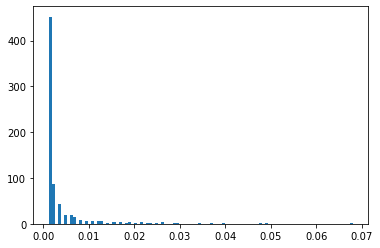

In [21]:
plt.hist(df15.degree_centrality, bins=100)

In [25]:
df15.subreddit.to_csv('subreddits.csv', index=False, header=False)

In [27]:
import csv
with open('subreddits.csv', newline='') as f:
    reader = csv.reader(f)
    subreddits = list(reader)

In [30]:
subreddits[0][0]

'aspiememes'